## Imports

In [9]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

## Settings

In [10]:
in_folder = '/home/drevital/obstacles_classification_datasets/rgb_6/train/obstacle'
imname = '5_2412_.03_2022-01-13--10-59-12_.jpg'
class_name = 'obstacle'

# Parameters used in the diff_metric to diff_coef assignent function
alfa = 3
beta = 1.5
gamma = 8
swc = 1.0 # sample weight coefficient
diff_threshold = 50
std_threshold_dist = 1.5 # Distance from std to apply sample_weight correction

# Define Mask Threshold
threshold = 50

## Define curve to assign diff_coef according to diff_metric

In [11]:
def diff_metric_to_diff_coef(sigma_dist):
    
    # Based on Sigmoid
    # adding alpha, beta and gamma controls, as explained at the
    # beginning of this notebook
    
    return 1/(1 + np.exp(-(sigma_dist*alfa-beta)*gamma))

## Calculate sample_weight

In [12]:
im_path = os.path.join(in_folder, imname)
pair = cv2.imread(im_path)

# Generate diff mask            
w = pair.shape[1]
ref = pair[:, :w//2]
current = pair[:, w//2:]
diff = cv2.subtract(ref, current)
agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
_, mask = cv2.threshold(agg_rgb, diff_threshold, 255, cv2.THRESH_BINARY)

# Calculate diff_coeff
h = mask.shape[0]
w = mask.shape[1]
area = h * w
diff_metric = (np.sum(mask)/255)/area
if class_name == 'obstacle':
    diff_metric = 1.0 - diff_metric            
mean = np.mean(diff_metric)
std = np.std(diff_metric)
diff_threshold = mean + std_threshold_dist * std
sigma_dist = abs(diff_metric - diff_threshold)/std
diff_coef = 0.0 # By default, if this image isn't an "outlier" for its class
if class_name == 'obstacle' and diff_metric < diff_threshold  or\
   class_name == 'no_obstacle' and diff_metric > diff_threshold:
    diff_coef = diff_metric_to_diff_coef(sigma_dist)
sample_weight = 1.0 + swc * diff_coef

/home/drevital/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


## Generate <ref, current, mask> triplet from <ref, current> pair

In [13]:
w = pair.shape[1]
ref = pair[:, :w//2]
current = pair[:, w//2:]
diff = cv2.absdiff(current, ref)
agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
_, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

# old morphological operations
copyImg = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=1)  # reduce noise
copyImg = cv2.dilate(copyImg, np.ones((7, 7), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
copyImg = cv2.dilate(copyImg, np.ones((9, 9), np.uint8), iterations=1)
kernel = np.ones((11, 11), np.uint8)  # kernel for dilation

# increase area to an object
copyImg = cv2.dilate(copyImg, kernel, iterations=2)
copyImg = cv2.dilate(copyImg, np.ones((13, 13), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((11, 11), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)

mask = copyImg 
concat = cv2.hconcat([ref[:, :, 1], current[:, :, 1], mask])

## Display Concatenated Image

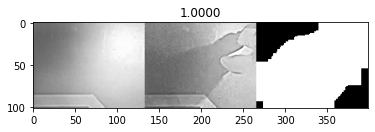

In [14]:
plt.imshow(concat, cmap='gray', vmin=0, vmax=255)
plt.title(f'{sample_weight:.4f}')
plt.show()